### Imports
Lots of these aren't necessary but I've copied and pasted it straight from the Explore gene.ipynb notebook.

In [1]:
import pandas as pd
import scipy.stats
import re

import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

from sklearn.metrics import roc_curve, auc, roc_auc_score
import numpy as np

from sklearn.metrics import confusion_matrix

import matplotlib.style #Some style nonsense
import matplotlib as mpl #Some more style nonsense
mpl.rcParams['figure.dpi']=300 # dots per inch

In [2]:
calculatedProperties = pd.read_csv("FH_complete_mutation_summary.csv")
calculatedProperties.head()

,Unnamed: 0,Residue,AAfrom,AAto,rhapsodyscore,rhapsodyclass,polyphenscore,polyphenclass,Foldx_energy,Rosetta_energy,Mutation,average_energy,RSA,Mindist_bindingsiteA,Mindist_hinge
0,0,49,S,A,0.086,neutral,0.00,neutral,0.061363,3.265,S49A,1.663182,0.992308,23.461148,33.7131
1,1,49,S,C,0.535,neutral,0.86,deleterious,0.067352,7.990,S49C,4.028676,0.992308,23.461148,33.7131
2,2,49,S,D,0.052,neutral,0.00,neutral,-0.103203,1.891,S49D,0.893899,0.992308,23.461148,33.7131
3,3,49,S,E,0.049,neutral,0.00,neutral,-0.086741,0.983,S49E,0.448129,0.992308,23.461148,33.7131
4,4,49,S,F,0.529,neutral,0.62,deleterious,0.182080,4.837,S49F,2.509540,0.992308,23.461148,33.7131


In [3]:
calculatedProperties = calculatedProperties.drop(columns = ["Mutation","Unnamed: 0", "rhapsodyclass","rhapsodyscore","polyphenscore","polyphenclass"])
calculatedProperties

,Residue,AAfrom,AAto,Foldx_energy,Rosetta_energy,average_energy,RSA,Mindist_bindingsiteA,Mindist_hinge
0,49,S,A,0.061363,3.265,1.663182,0.992308,23.461148,33.713100
1,49,S,C,0.067352,7.990,4.028676,0.992308,23.461148,33.713100
2,49,S,D,-0.103203,1.891,0.893899,0.992308,23.461148,33.713100
3,49,S,E,-0.086741,0.983,0.448129,0.992308,23.461148,33.713100
4,49,S,F,0.182080,4.837,2.509540,0.992308,23.461148,33.713100
...,...,...,...,...,...,...,...,...,...
8773,510,K,S,0.571362,1.871,1.221181,0.717073,14.891393,15.359364
8774,510,K,T,0.862076,1.330,1.096038,0.717073,14.891393,15.359364
8775,510,K,V,1.125190,-0.576,0.274595,0.717073,14.891393,15.359364
8776,510,K,W,0.686269,-0.158,0.264134,0.717073,14.891393,15.359364


In [4]:
BayesDel = pd.read_csv("./FH_mutations_BayesDel_Cleaned_2.csv")

In [5]:
# need to match column names to that of calculatedProperties
BayesDel.rename(columns={
    'aapos': 'Residue',
    'aaalt': 'AAto',
    'aaref': 'AAfrom'
}, inplace=True)

BayesDel.head()

,#chr,pos(1-based),ref,alt,genename,rs_dbSNP,AAfrom,AAto,Residue,HGVSc_VEP,HGVSp_VEP,BayesDel_addAF_score,BayesDel_noAF_score,BayesDel_addAF_rankscore
0,1,241497828,T,A,FH,.,X,C,511,c.1533A>T,p.Ter511CysextTer3,0.016367,-0.214267,0.53578
1,1,241497828,T,C,FH,.,X,W,511,c.1533A>G,p.Ter511TrpextTer3,0.048540,-0.168052,0.57861
2,1,241497828,T,G,FH,.,X,C,511,c.1533A>C,p.Ter511CysextTer3,0.019965,-0.209098,0.54067
3,1,241497829,C,A,FH,.,X,L,511,c.1532G>T,p.Ter511LeuextTer3,-0.136883,-0.434399,0.30031
4,1,241497829,C,G,FH,rs2147911168,X,S,511,c.1532G>C,p.Ter511SerextTer3,-0.148895,-0.451654,0.28133


In [6]:
# there's only some tables I want to keep
BayesDel = BayesDel[["AAfrom","AAto","Residue","BayesDel_addAF_score","BayesDel_noAF_score","BayesDel_addAF_rankscore"]]

In [7]:
# merging datasets to get ready for binary classification
BayesDel_calc = BayesDel.merge(calculatedProperties, on = ["Residue", "AAfrom", "AAto"])

In [8]:
bs_calc = BayesDel_calc[BayesDel_calc['BayesDel_noAF_score'] < -0.057]
ds_calc = BayesDel_calc[BayesDel_calc['BayesDel_noAF_score'] >= -0.057]

In [9]:
bs_calc = bs_calc[["Residue","average_energy"]]
ds_calc = ds_calc[["Residue","average_energy"]]

In [10]:
# Group by residue, averaging energies
grouped_data = bs_calc.groupby("Residue", as_index=False)["average_energy"].mean()

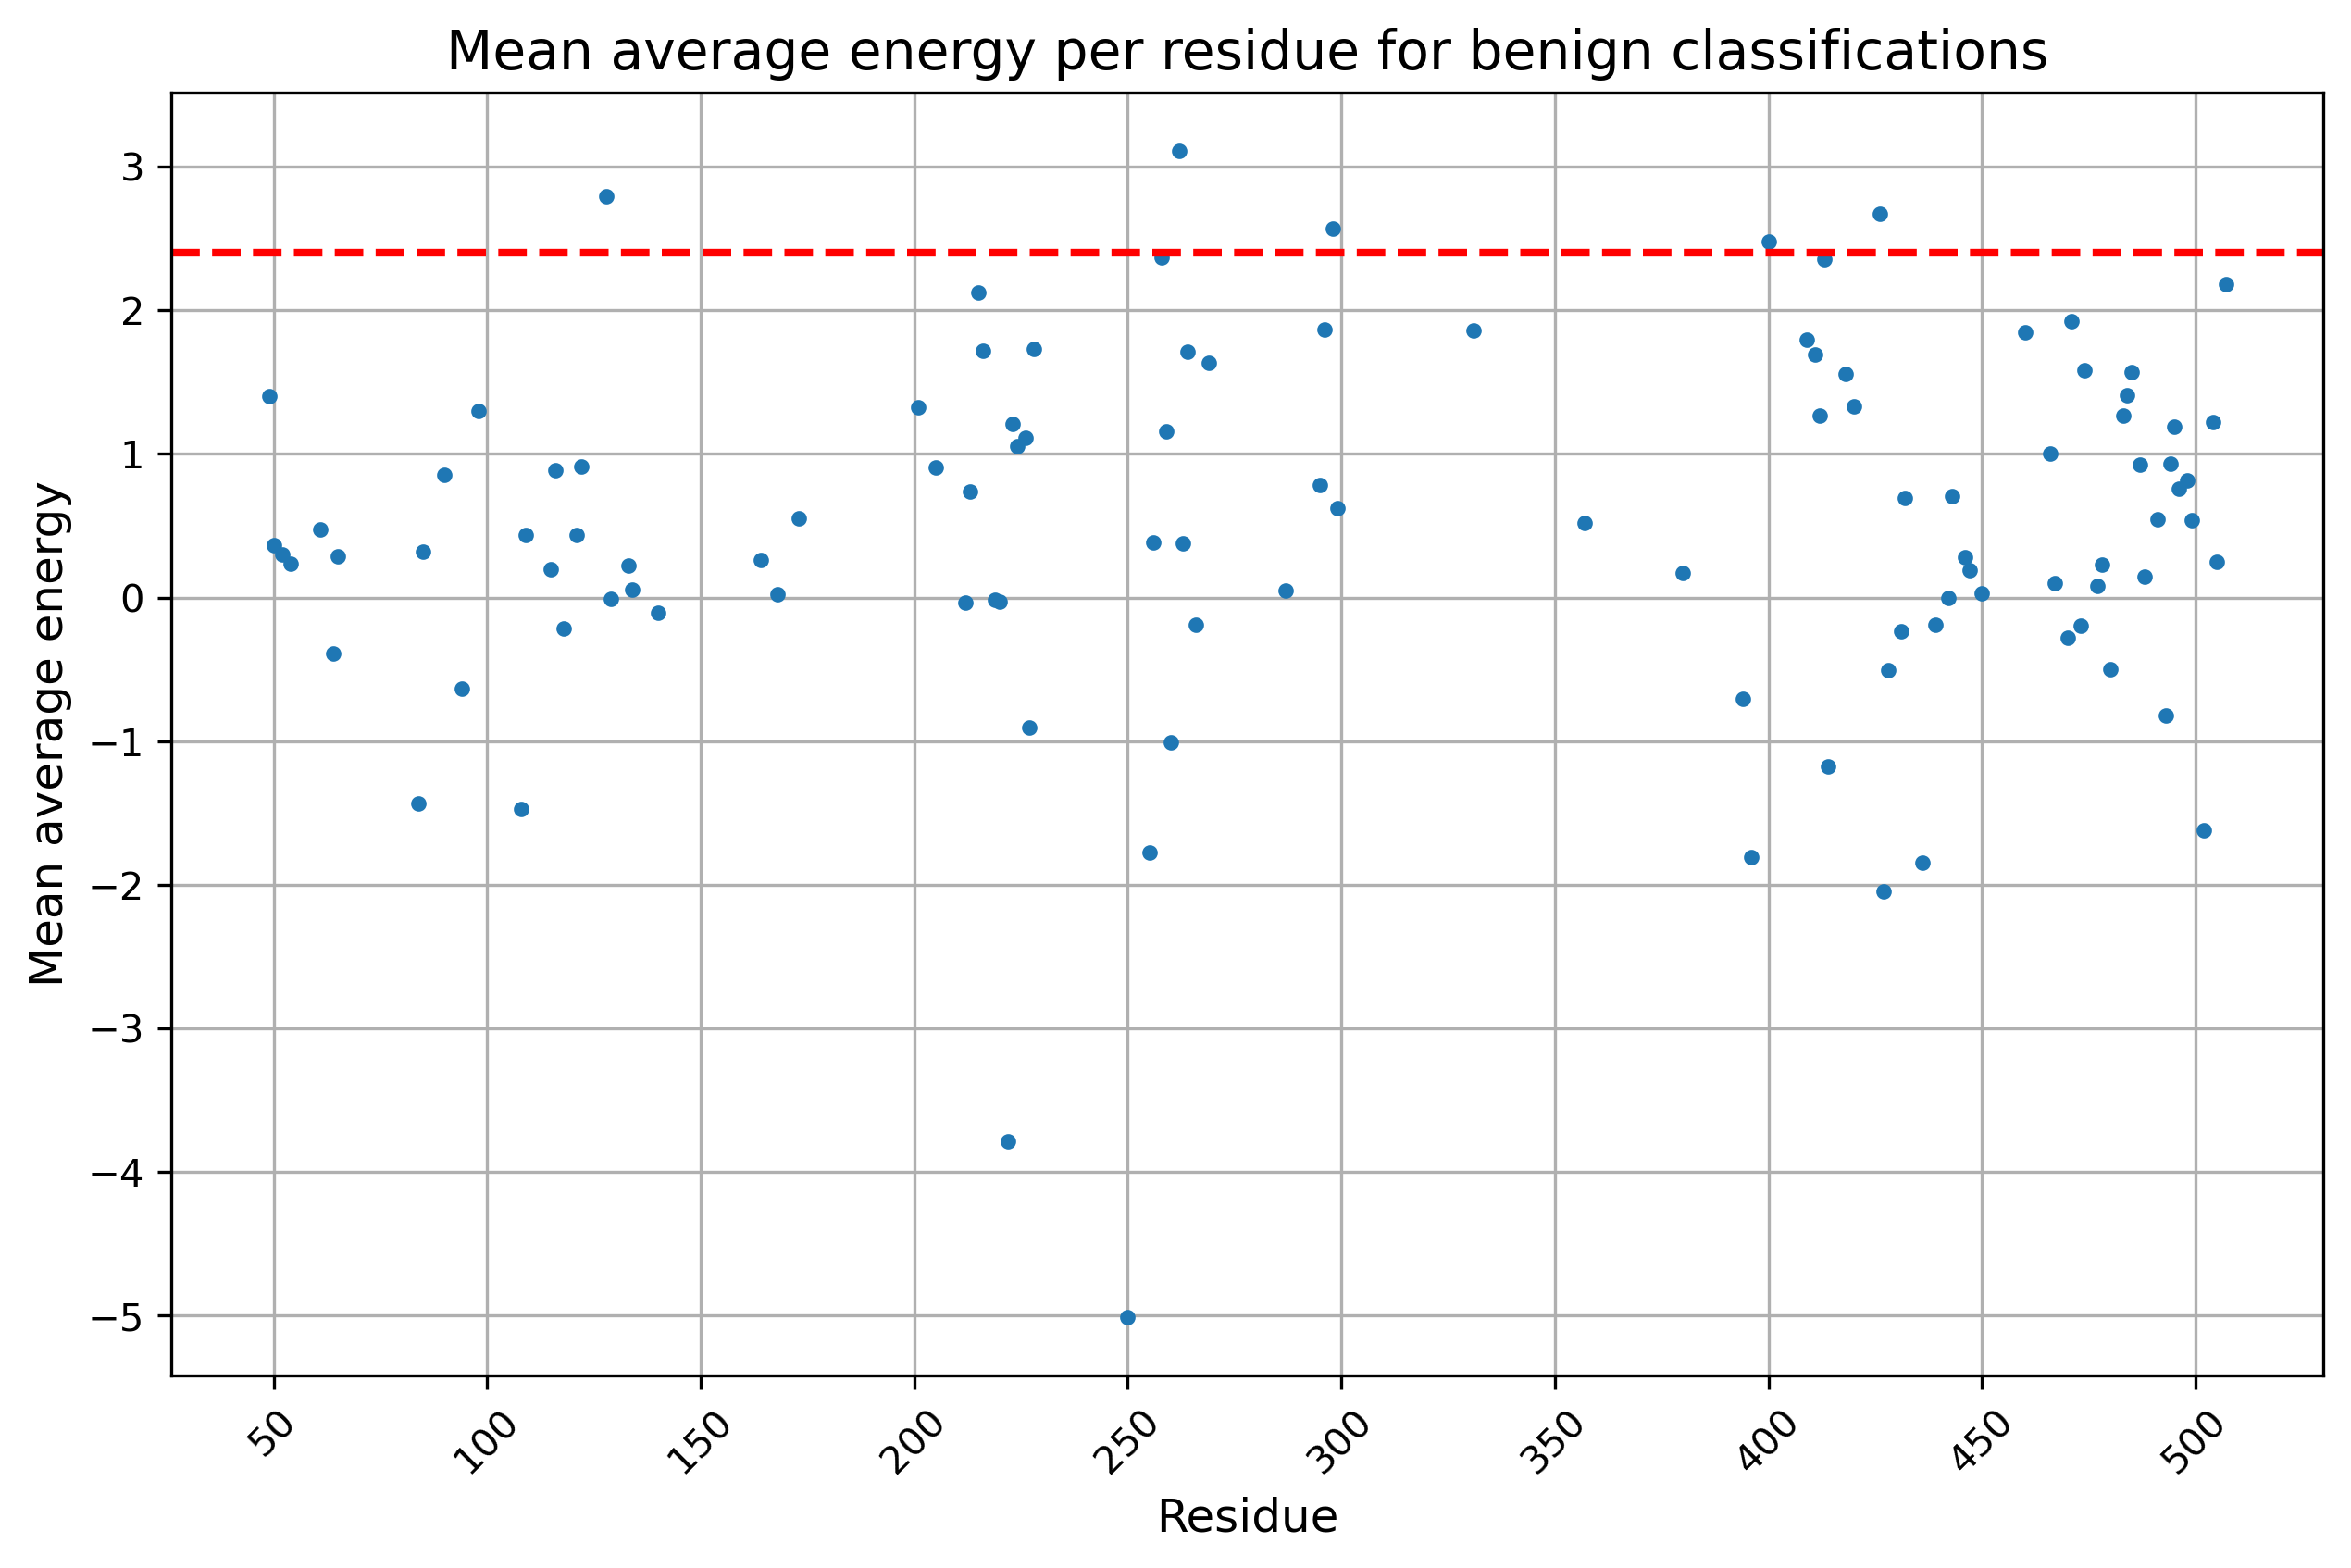

In [11]:
# Create figure
plt.figure(figsize=(10, 6))

# Plot
plt.plot(grouped_data["Residue"], grouped_data["average_energy"],'.')
# Cutoff horizontal line
plt.axhline(y=2.4, color="red", linestyle="--", linewidth=2, label="Threshold (2.4)")

# Labels and title
plt.xlabel("Residue", fontsize=12)
plt.ylabel("Mean average energy", fontsize=12)
plt.title("Mean average energy per residue for benign classifications", fontsize=14)

# Get min and max residue values for x-axis ticks
min_residue = grouped_data["Residue"].min()
max_residue = grouped_data["Residue"].max()

# Set x-axis ticks every 50 residues
ticks = np.arange(min_residue+1, max_residue + 1, 50)
plt.xticks(ticks, rotation=45)

plt.grid()
plt.show()

In [12]:
# Group by residue, averaging energies
grouped_data = ds_calc.groupby("Residue", as_index=False)["average_energy"].mean()

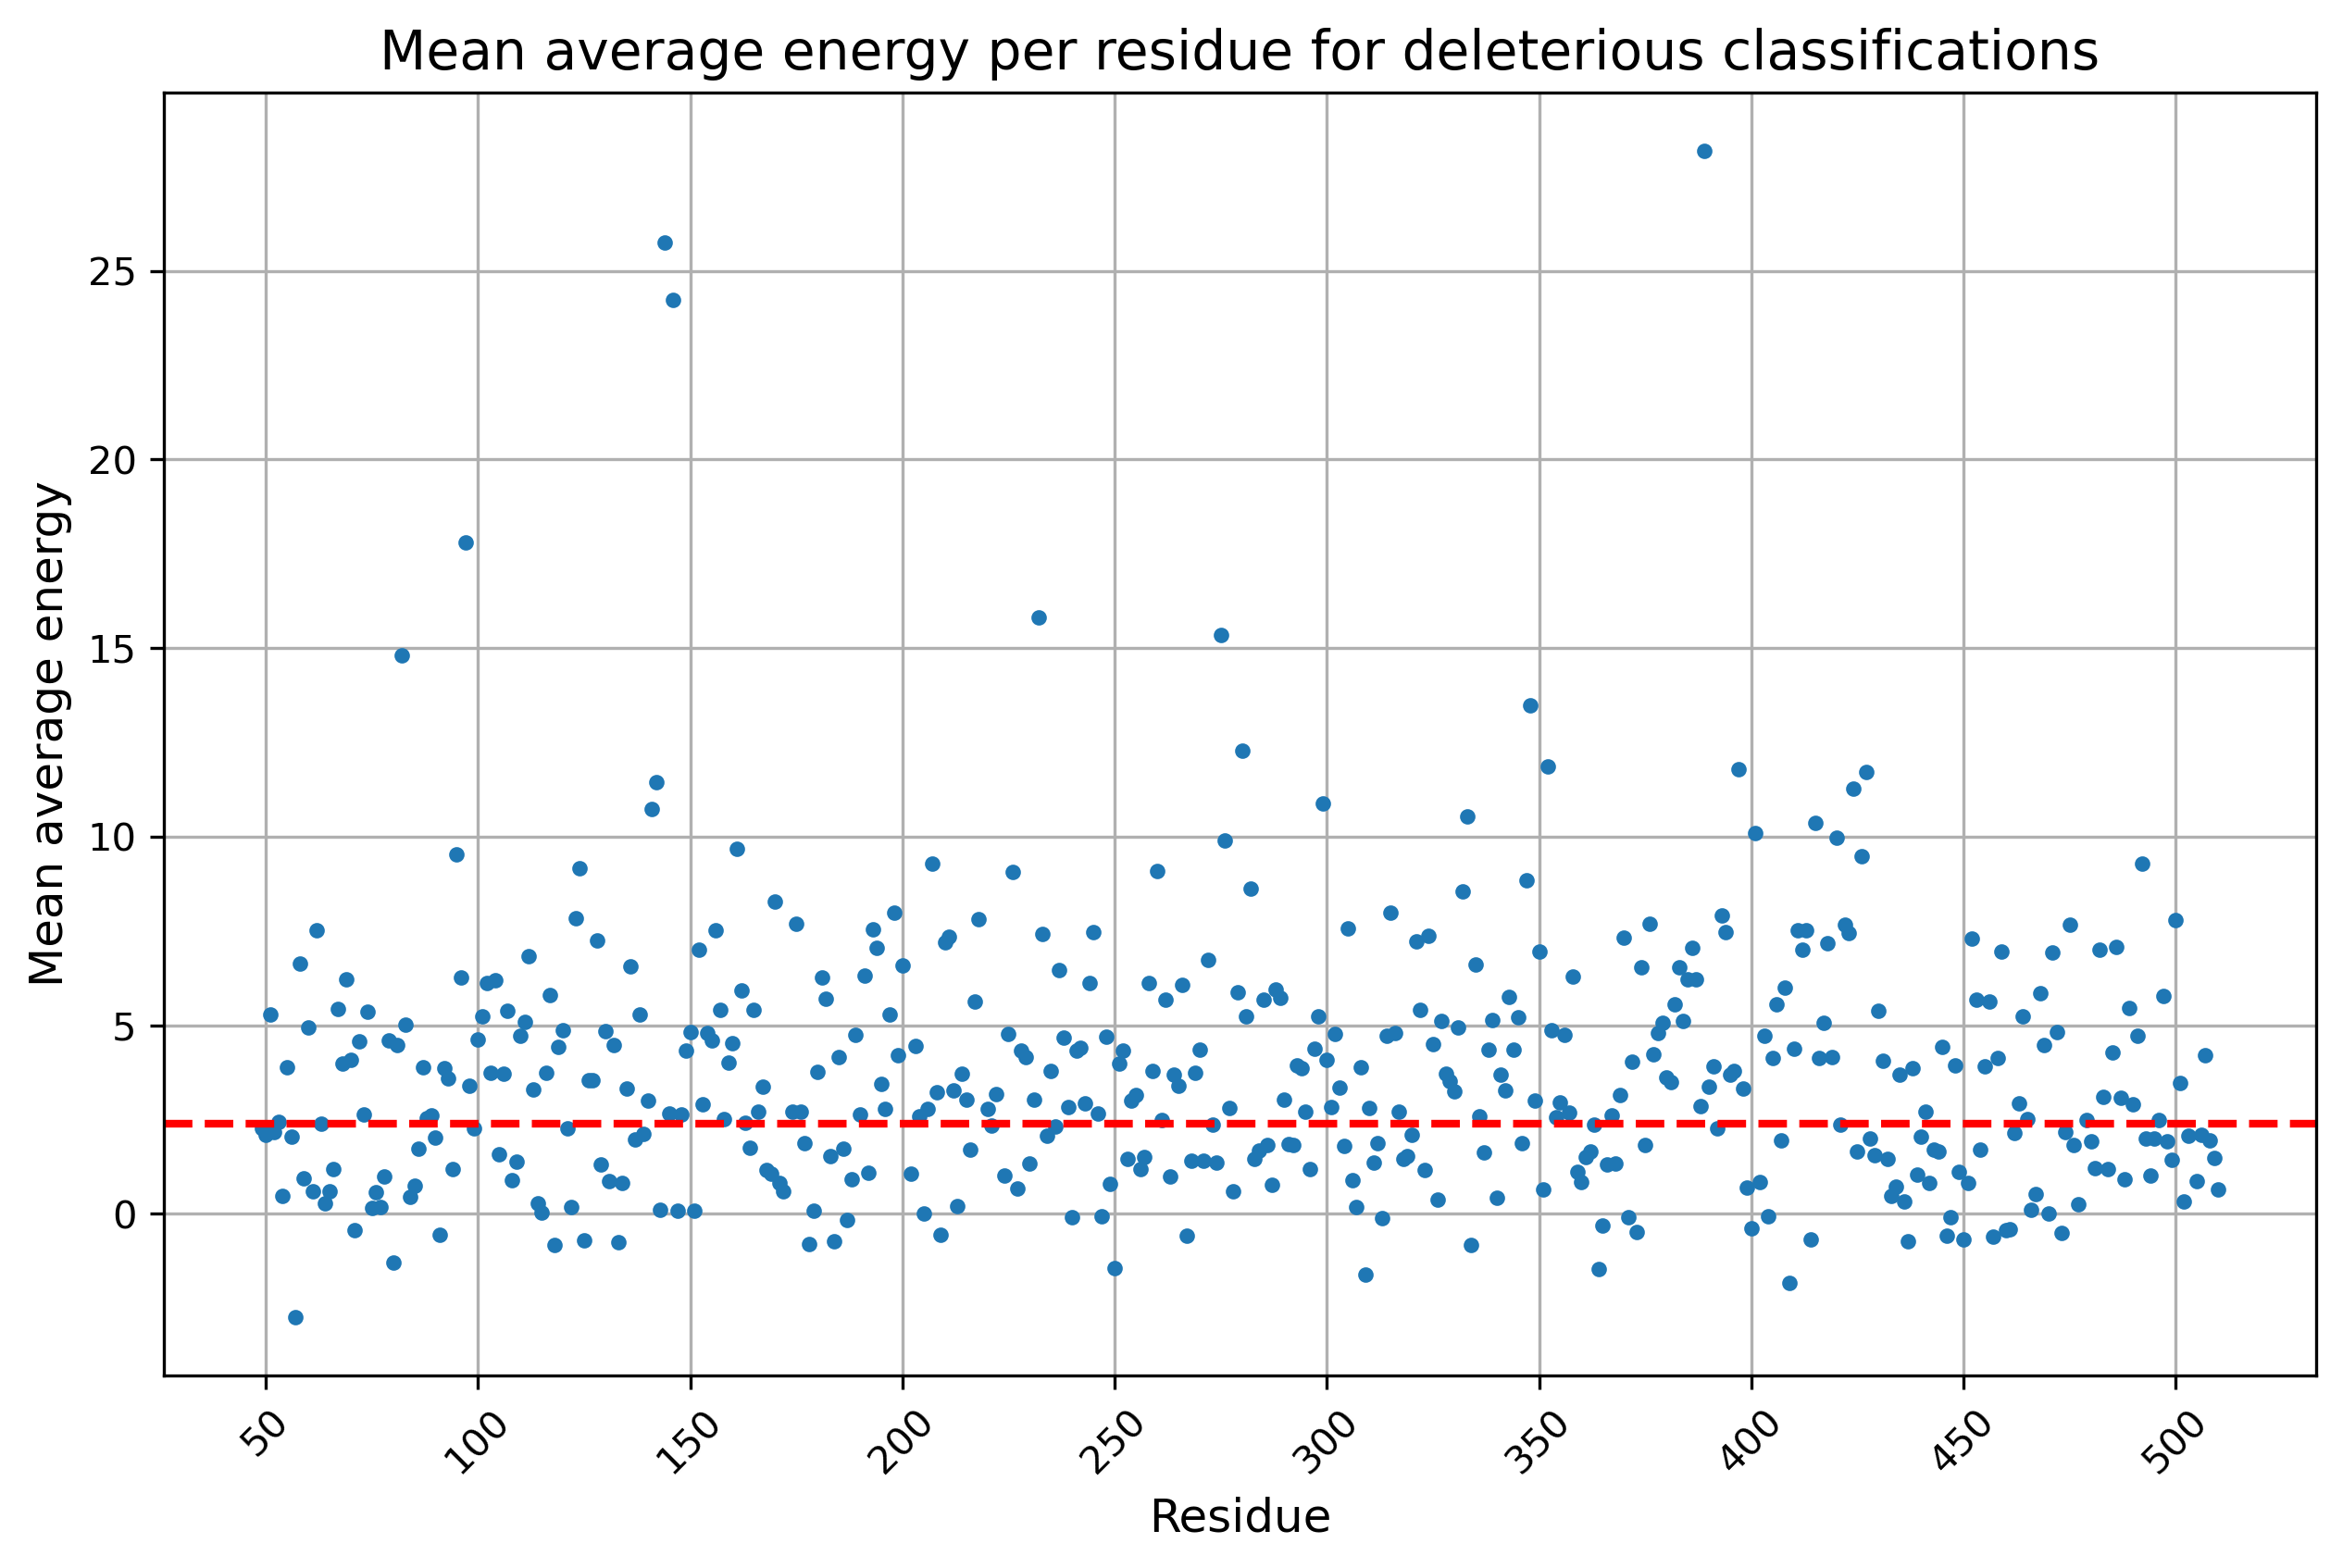

In [13]:
# Create figure
plt.figure(figsize=(10, 6))

# Plot
plt.plot(grouped_data["Residue"], grouped_data["average_energy"],'.')
# Cutoff horizontal line
plt.axhline(y=2.4, color="red", linestyle="--", linewidth=2)

# Labels and title
plt.xlabel("Residue", fontsize=12)
plt.ylabel("Mean average energy", fontsize=12)
plt.title("Mean average energy per residue for deleterious classifications", fontsize=14)

# Get min and max residue values for x-axis ticks
min_residue = grouped_data["Residue"].min()
max_residue = grouped_data["Residue"].max()

# Set x-axis ticks every 50 residues
ticks = np.arange(min_residue+1, max_residue + 1, 50)
plt.xticks(ticks, rotation=45)

plt.grid(True)
plt.show()

In [14]:
BayesDel_calc[["Residue","average_energy"]]
# Group by residue, averaging energies
grouped_data = BayesDel_calc.groupby("Residue", as_index=False)["average_energy"].mean()

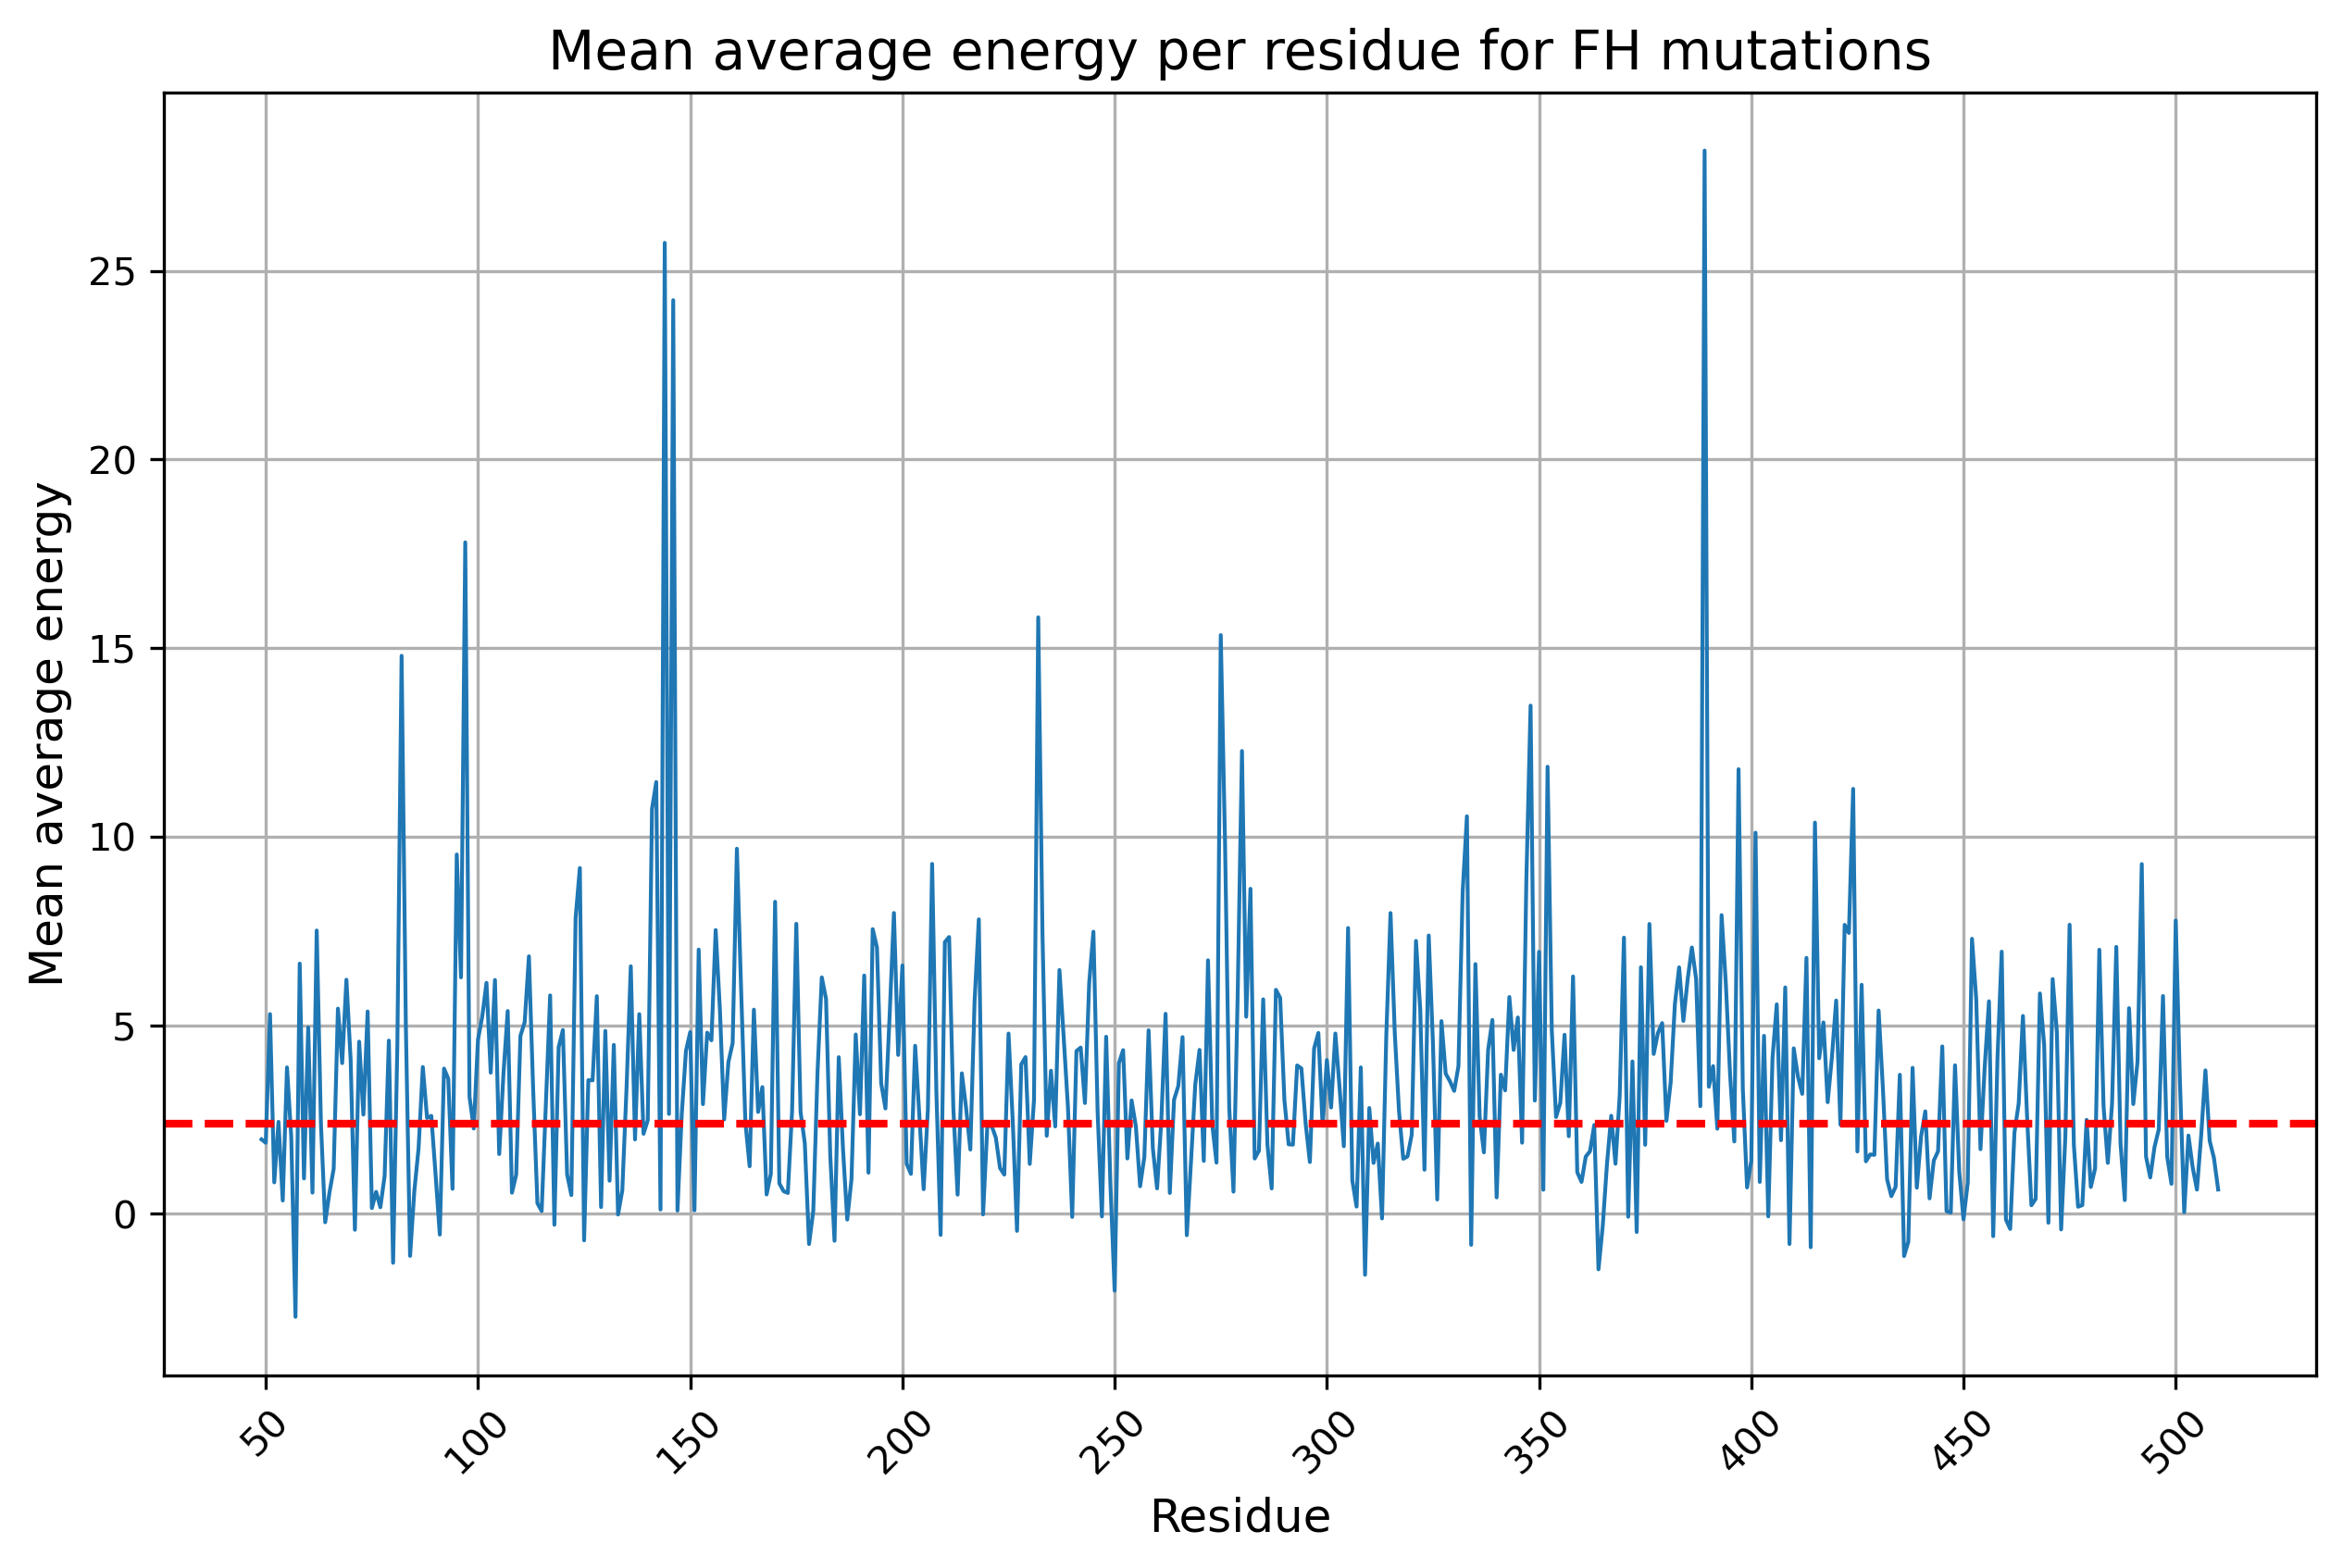

In [15]:
# Create figure
plt.figure(figsize=(10, 6))

# Plot
plt.plot(grouped_data["Residue"], grouped_data["average_energy"],linewidth=1)
# Cutoff horizontal line
plt.axhline(y=2.4, color="red", linestyle="--", linewidth=2)

# Labels and title
plt.xlabel("Residue", fontsize=12)
plt.ylabel("Mean average energy", fontsize=12)
plt.title("Mean average energy per residue for FH mutations", fontsize=14)

# Get min and max residue values for x-axis ticks
min_residue = grouped_data["Residue"].min()
max_residue = grouped_data["Residue"].max()

# Set x-axis ticks every 50 residues
ticks = np.arange(min_residue+1, max_residue + 1, 50)
plt.xticks(ticks, rotation=45)

plt.grid(True)
plt.show()

In [16]:
# Count the frequency of each residue
benign_residue_count = bs_calc["Residue"].value_counts().reset_index()
benign_residue_count.columns = ["Residue", "Count"]  # Rename columns

# Sort by Residue number for better visualization
benign_residue_count = benign_residue_count.sort_values("Residue")

In [17]:
# Count the frequency of each residue
del_residue_count = ds_calc["Residue"].value_counts().reset_index()
del_residue_count.columns = ["Residue", "Count"]  # Rename columns

# Sort by Residue number for better visualization
del_residue_count = del_residue_count.sort_values("Residue")

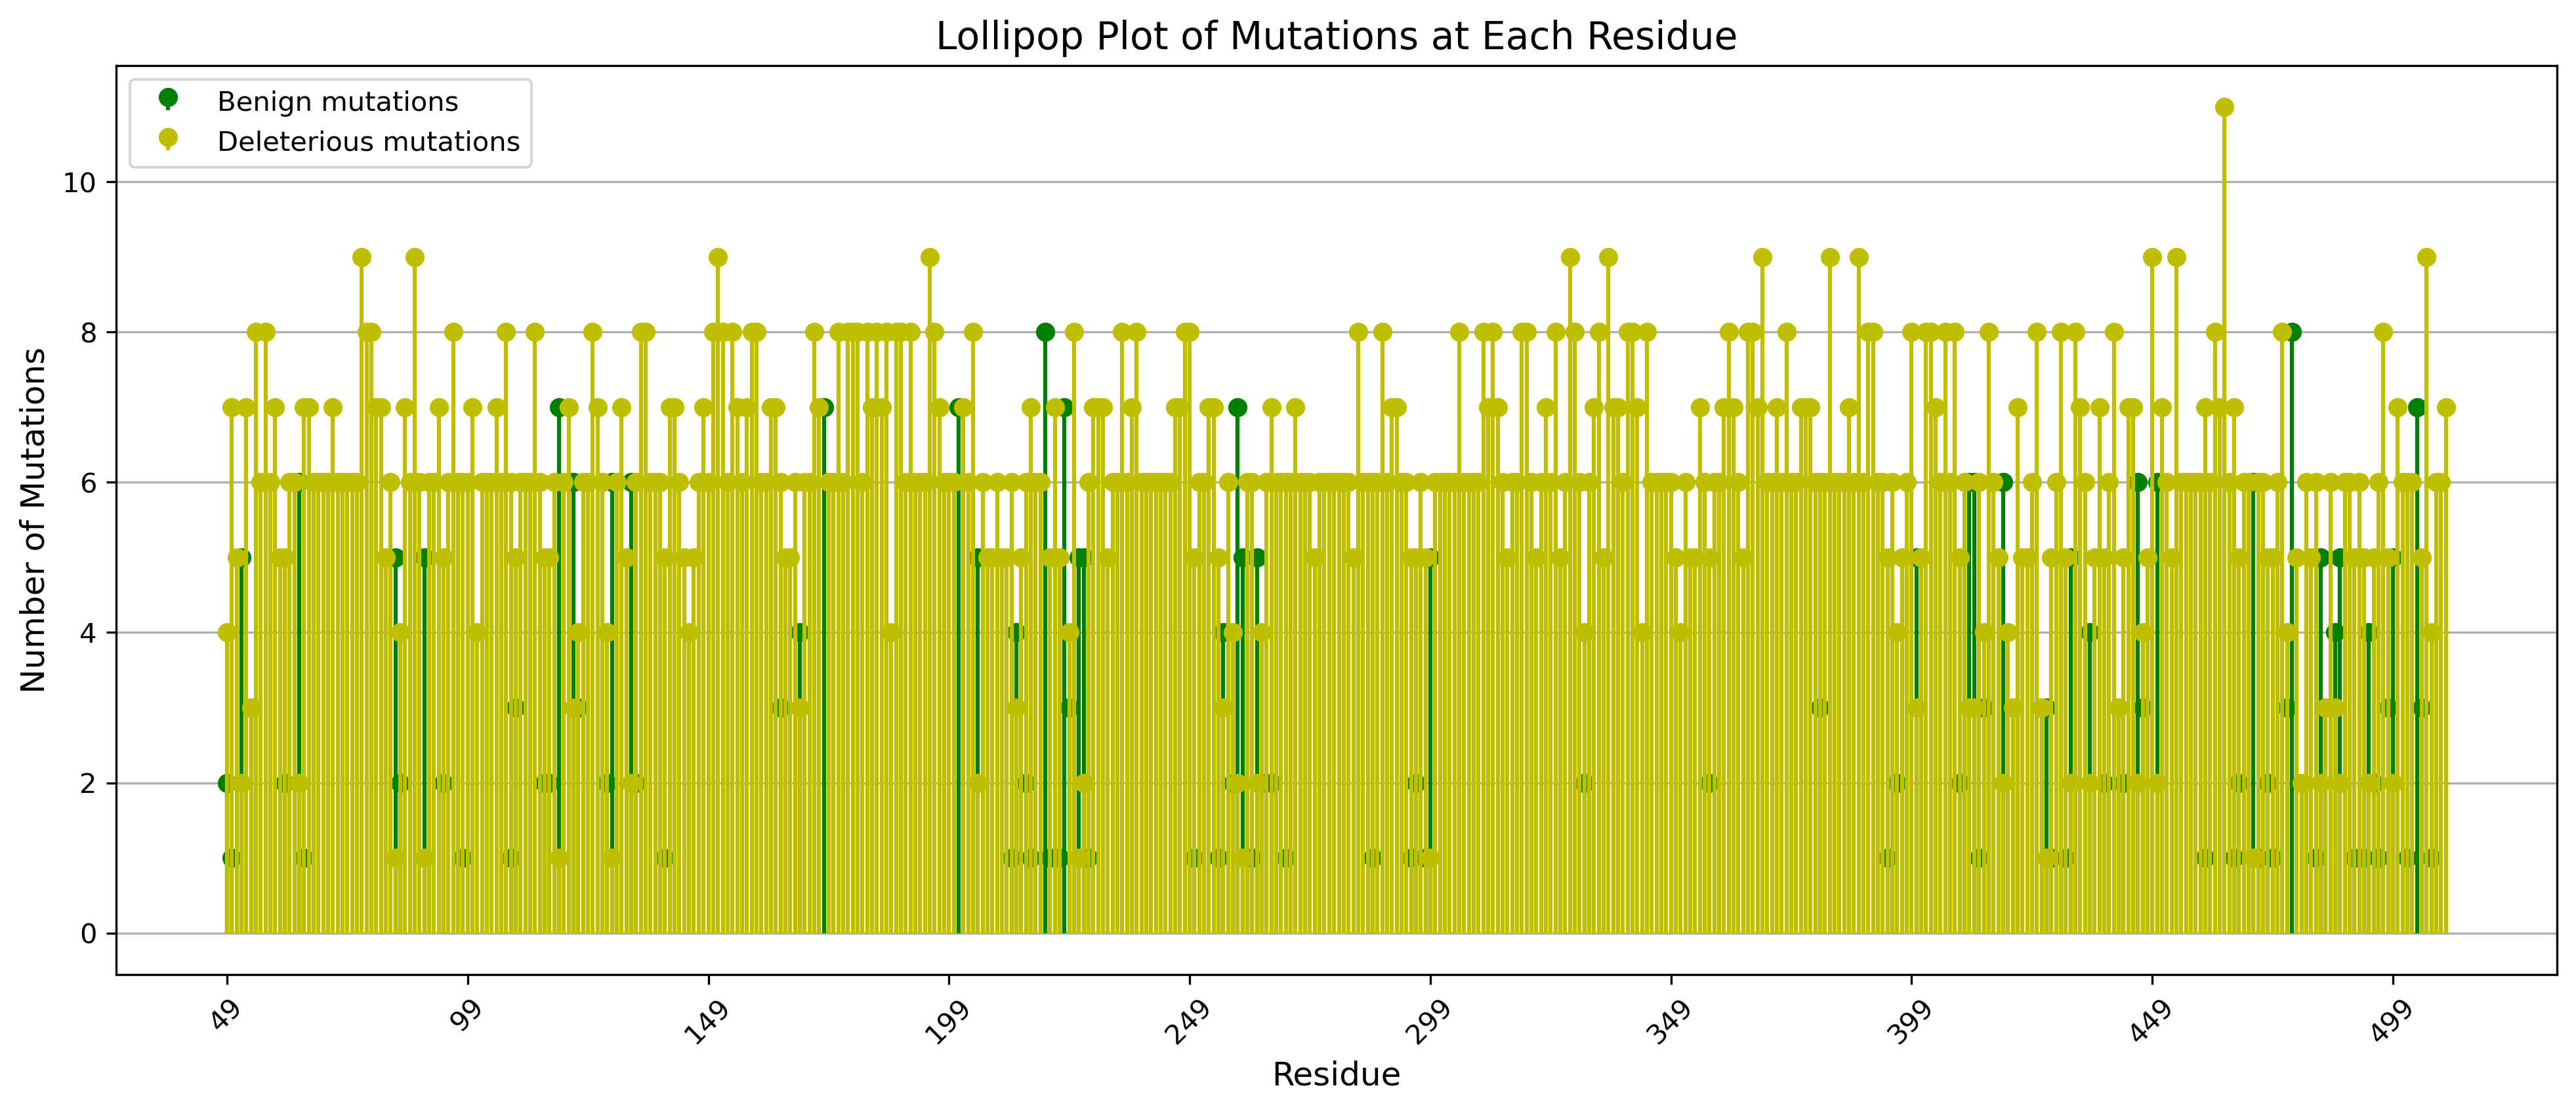

In [18]:
# Create figure
plt.figure(figsize=(16, 6))

# Plot lollipop lines with different colors
plt.stem(benign_residue_count["Residue"], benign_residue_count["Count"], 
         linefmt="g-", markerfmt="go", basefmt=" ", label="Benign mutations")  # Green

plt.stem(del_residue_count["Residue"], del_residue_count["Count"], 
         linefmt="y-", markerfmt="yo", basefmt=" ", label="Deleterious mutations")  # Red

# Labels and title
plt.xlabel("Residue", fontsize=12)
plt.ylabel("Number of Mutations", fontsize=12)
plt.title("Lollipop Plot of Mutations at Each Residue", fontsize=14)

# Set x-axis ticks every 50 residues
min_residue = min(benign_residue_count["Residue"].min(), del_residue_count["Residue"].min())
max_residue = max(benign_residue_count["Residue"].max(), del_residue_count["Residue"].max())
ticks = np.arange(min_residue, max_residue + 1, 50)
plt.xticks(ticks, rotation=45)

# Add grid and legend
plt.grid(axis="y")
plt.legend()

plt.show()
